In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

### Загрузка данных

In [2]:
df_transactions = pd.read_parquet("transaction_fraud_data.parquet")

In [3]:
df_currency = pd.read_parquet("historical_currency_exchange.parquet")

In [4]:
pd.set_option("display.max_columns", None)

Задание: провести разведочный анализ данных, придумать продуктовые и технические гипотезы — какую ценность можете извлечь из данных для организации, которая предоставила данные.

In [5]:
df_transactions.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,Unknown City,medium,Platinum Credit,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,Unknown City,medium,Premium Debit,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,Unknown City,medium,Basic Debit,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


In [6]:
df_currency.head()

,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD
0,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.736400,94.133735,1.280156,1
1,2024-10-01,1.442917,5.444170,1.352168,0.897557,0.746956,143.831429,19.667561,1670.694524,92.898519,1.284352,1
2,2024-10-02,1.449505,5.425444,1.348063,0.903056,0.752241,143.806861,19.606748,1669.653006,94.583198,1.286983,1
3,2024-10-03,1.456279,5.442044,1.351451,0.906018,0.754584,146.916773,19.457701,1670.097873,95.655442,1.294391,1
4,2024-10-04,1.460930,5.477788,1.355260,0.906452,0.761891,146.592323,19.363467,1649.763738,94.755337,1.296800,1


### Изучение данных

In [7]:
df_transactions["date"] = df_transactions["timestamp"].dt.date

In [8]:
df_currency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    31 non-null     object 
 1   AUD     31 non-null     float64
 2   BRL     31 non-null     float64
 3   CAD     31 non-null     float64
 4   EUR     31 non-null     float64
 5   GBP     31 non-null     float64
 6   JPY     31 non-null     float64
 7   MXN     31 non-null     float64
 8   NGN     31 non-null     float64
 9   RUB     31 non-null     float64
 10  SGD     31 non-null     float64
 11  USD     31 non-null     int64  
dtypes: float64(10), int64(1), object(1)
memory usage: 3.0+ KB


In [9]:
df_merged = df_transactions.merge(df_currency, on="date", how="left")

In [10]:
df_merged.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,Unknown City,medium,Platinum Credit,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,Unknown City,medium,Premium Debit,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,Unknown City,medium,Basic Debit,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1


In [11]:
def convert_to_usd(row: pd.Series) -> float or None:
    """"""
    rate = row[row["currency"]]
    
    return row["amount"] / rate if pd.notnull(rate) else None


In [12]:
df_merged["amount_usd"] = df_merged.apply(convert_to_usd, axis=1)

In [13]:
df_merged.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD,amount_usd
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,394.658011
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,619.905757
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,Unknown City,medium,Platinum Credit,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,719.506409
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,Unknown City,medium,Premium Debit,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,436.808287
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,Unknown City,medium,Basic Debit,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,434.430069


In [14]:
results = {}

results["unique_tx_ids"] = df_merged["transaction_id"].is_unique
results["num_transactions"] = len(df_merged)
results["num_users"] = df_merged["customer_id"].nunique()

In [15]:
results

{'unique_tx_ids': False, 'num_transactions': 7483766, 'num_users': 4869}

#### По категориям

In [16]:
category_stats = df_merged.groupby("vendor_category").agg(
    total_amount=("amount_usd", "sum"),
    mean_amount=("amount_usd", "mean"),
    num_transactions=("transaction_id", "count")
).reset_index().sort_values("total_amount", ascending=False)

In [17]:
category_stats

,vendor_category,total_amount,mean_amount,num_transactions
7,Travel,9.739946e+08,1040.826006,935790
6,Retail,6.245196e+08,667.305228,935883
4,Healthcare,4.823310e+08,514.887331,936770
0,Education,4.802995e+08,514.491554,933542
2,Gas,4.801034e+08,513.259443,935401
3,Grocery,3.890553e+08,416.534478,934029
1,Entertainment,3.279550e+08,350.314504,936173
5,Restaurant,3.026927e+08,323.328116,936178


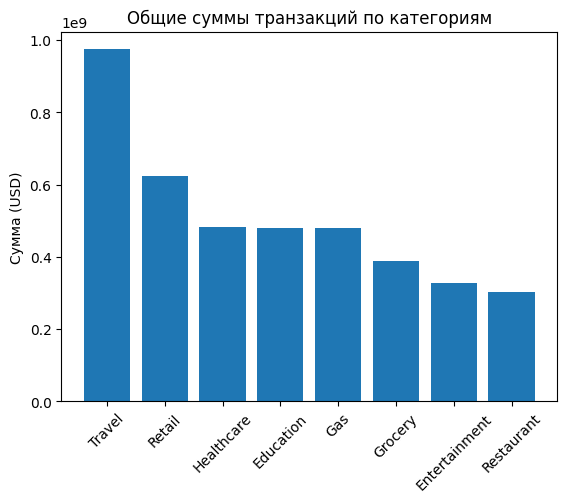

In [18]:
plt.bar(category_stats["vendor_category"], category_stats["total_amount"])
plt.title("Общие суммы транзакций по категориям")
plt.xticks(rotation=45)
plt.ylabel("Сумма (USD)")
plt.show()

#### По подкатегориям

In [19]:
subcategory_stats = df_merged.groupby("vendor_type").agg(
    total_amount=("amount_usd", "sum"),
    mean_amount=("amount_usd", "mean"),
    num_transactions=("transaction_id", "count")
).reset_index().sort_values("total_amount", ascending=False)

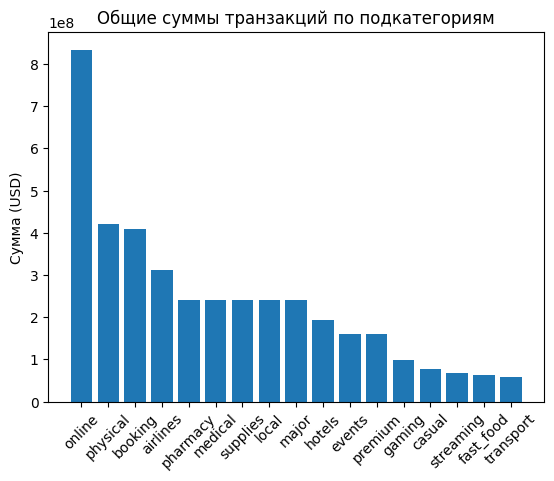

In [20]:
plt.bar(subcategory_stats["vendor_type"], subcategory_stats["total_amount"])
plt.title("Общие суммы транзакций по подкатегориям")
plt.xticks(rotation=45)
plt.ylabel("Сумма (USD)")
plt.show()

#### По странам

In [21]:
country_stats = df_merged.groupby("country").agg(
    total_amount=("amount_usd", "sum"),
    mean_amount=("amount_usd", "mean"),
    num_transactions=("transaction_id", "count")
).reset_index().sort_values("total_amount", ascending=False)

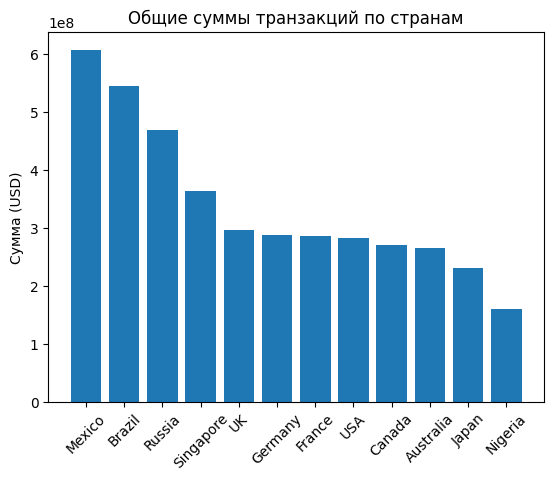

In [22]:
plt.bar(country_stats["country"], country_stats["total_amount"])
plt.title("Общие суммы транзакций по странам")
plt.xticks(rotation=45)
plt.ylabel("Сумма (USD)")
plt.show()

#### По категориям в разрезе isFraud

In [23]:
category_fraud_stats = df_merged.groupby(["vendor_category", "is_fraud"]).agg(
    total_amount=("amount_usd", "sum"),
    mean_amount=("amount_usd", "mean"),
    num_transactions=("transaction_id", "count")
).reset_index()

country_fraud_stats = df_merged.groupby(["country", "is_fraud"]).agg(
    total_amount=("amount_usd", "sum"),
    mean_amount=("amount_usd", "mean"),
    num_transactions=("transaction_id", "count")
).reset_index()

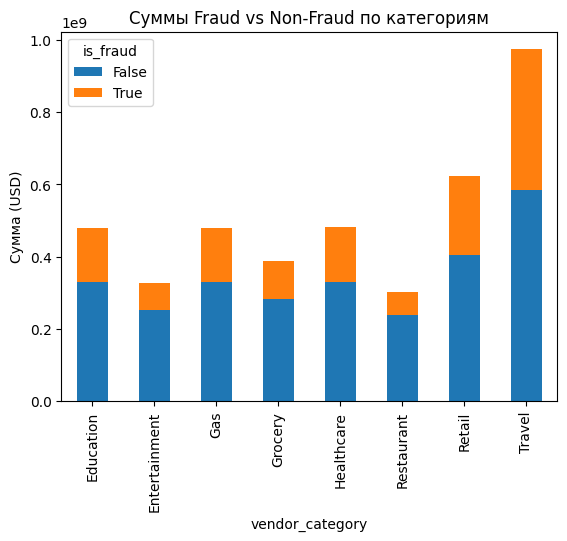

In [24]:
pivot_cat = category_fraud_stats.pivot(index="vendor_category", columns="is_fraud", values="total_amount").fillna(0)
pivot_cat.plot(kind="bar", stacked=True)
plt.title("Суммы Fraud vs Non-Fraud по категориям")
plt.ylabel("Сумма (USD)")
plt.show()

#### Доля Fraud по категориям

In [25]:
fraud_by_category = df_merged.groupby("vendor_category")["is_fraud"].mean().reset_index()
fraud_by_subcategory = df_merged.groupby("vendor_type")["is_fraud"].mean().reset_index()

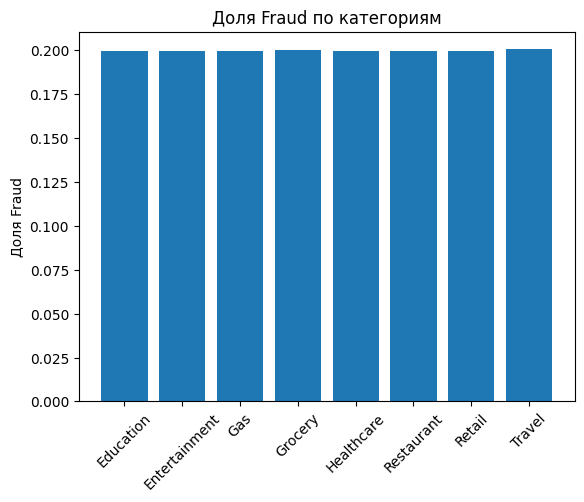

In [26]:
plt.bar(fraud_by_category["vendor_category"], fraud_by_category["is_fraud"])
plt.title("Доля Fraud по категориям")
plt.ylabel("Доля Fraud")
plt.xticks(rotation=45)
plt.show()

#### Доля Fraud по подкатегориям

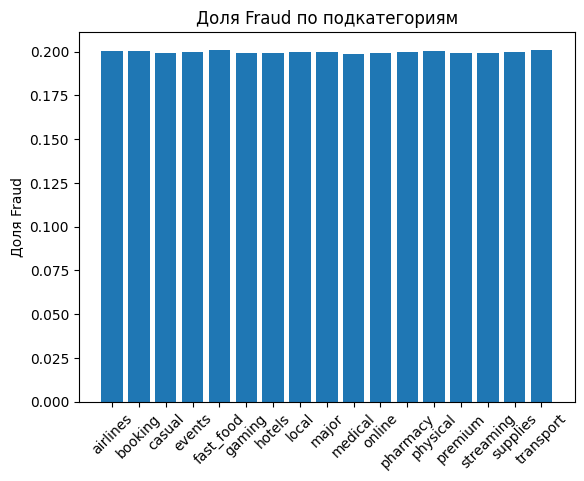

In [27]:
plt.bar(fraud_by_subcategory["vendor_type"], fraud_by_subcategory["is_fraud"])
plt.title("Доля Fraud по подкатегориям")
plt.ylabel("Доля Fraud")
plt.xticks(rotation=45)
plt.show()

#### Распределение суммы транзакций по isFraud

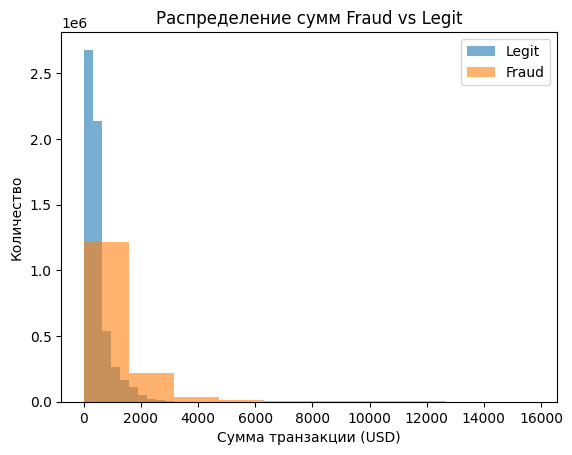

In [28]:
plt.hist(df_merged[df_merged["is_fraud"]==0]["amount_usd"], bins=10, alpha=0.6, label="Legit")
plt.hist(df_merged[df_merged["is_fraud"]==1]["amount_usd"], bins=10, alpha=0.6, label="Fraud")
plt.legend()
plt.xlabel("Сумма транзакции (USD)")
plt.ylabel("Количество")
plt.title("Распределение сумм Fraud vs Legit")
plt.show()

#### Зависимости от времени

In [29]:
df_merged["hour"] = pd.to_datetime(df_merged["timestamp"]).dt.hour
df_merged["dayofweek"] = pd.to_datetime(df_merged["timestamp"]).dt.dayofweek

In [30]:
fraud_by_hour = df_merged.groupby("hour")["is_fraud"].mean().reset_index()
fraud_by_day = df_merged.groupby("dayofweek")["is_fraud"].mean().reset_index()

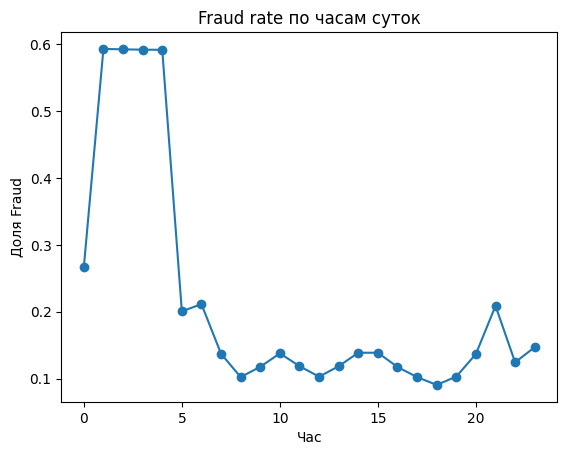

In [31]:
plt.plot(fraud_by_hour["hour"], fraud_by_hour["is_fraud"], marker="o")
plt.title("Fraud rate по часам суток")
plt.xlabel("Час")
plt.ylabel("Доля Fraud")
plt.show()

#### Зависимости от дней недели

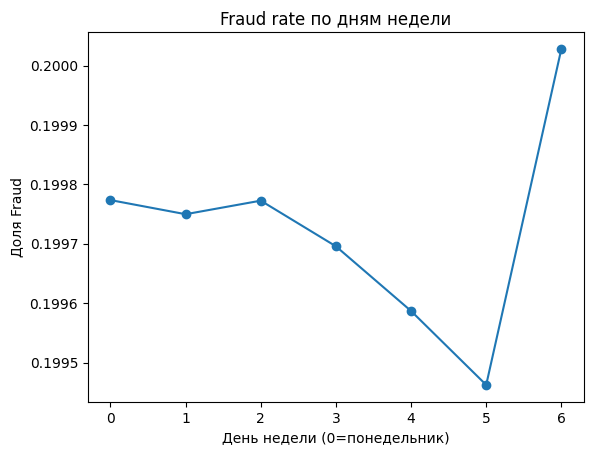

In [32]:
plt.plot(fraud_by_day["dayofweek"], fraud_by_day["is_fraud"], marker="o")
plt.title("Fraud rate по дням недели")
plt.xlabel("День недели (0=понедельник)")
plt.ylabel("Доля Fraud")
plt.show()

#### По типу устройства

In [33]:
device_stats = df_merged.groupby("device").agg(
    fraud_rate=("is_fraud", "mean"),
    total_amount=("amount_usd", "sum"),
    mean_amount=("amount_usd", "mean"),
    num_transactions=("transaction_id", "count")
).reset_index()

In [34]:
device_stats

,device,fraud_rate,total_amount,mean_amount,num_transactions
0,Android App,0.125070,5.687319e+08,505.037992,1126117
1,Chip Reader,1.000000,1.905342e+08,876.728816,217324
2,Chrome,0.123710,5.892208e+08,520.336571,1132384
3,Edge,0.116753,5.906993e+08,496.569609,1189560
4,Firefox,0.126831,5.759108e+08,513.769335,1120952
5,Magnetic Stripe,1.000000,1.893091e+08,871.572944,217204
6,NFC Payment,1.000000,1.892240e+08,873.937072,216519
7,Safari,0.126204,5.807019e+08,518.370435,1120245
8,iOS App,0.122703,5.866190e+08,513.020555,1143461


### Гипотезы

#### Детекция мошеннических транзакций

Детекция мошеннических транзакций может быть очень полезной задачей для бизнеса / продукта, потому что решив такую задачу, мы можем больше экономить на фроде, а также поддерживать имидж компании, что тоже может сказаться положительно на выручке.

Поэтому реализуем бейзлайн модели для детекции мошеннических транзакций.

В целях экономии времени, попробуем использовать 4 модели, обучать которые будем без предварительного отбора фич, а также без генерации новых фич и без подбора гиперпараметров модели.

In [35]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test) -> None:
    """"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\nМетрики для {name}:")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
    print("F1-score :", f1_score(y_test, y_pred, zero_division=0))
    print("ROC AUC  :", roc_auc_score(y_test, y_proba))
    
    return


In [36]:
df_ml = df_merged.copy()

In [37]:
y = df_ml["is_fraud"].astype(int)

Распарсим поле с активностью пользователя в последний час, потому что такие признаки могут оказаться очень полезными

In [38]:
activity_df = pd.json_normalize(df_ml["last_hour_activity"])
activity_df.index = df_ml.index

In [39]:
df_ml = pd.concat([df_ml, activity_df], axis=1)

In [40]:
df_ml.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD,amount_usd,hour,dayofweek,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,394.658011,0,0,1197,3.349856e+07,105,12,1.925481e+06
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,619.905757,0,0,509,2.011476e+07,100,12,5.149117e+06
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,Unknown City,medium,Platinum Credit,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,719.506409,0,0,332,3.916385e+07,97,12,1.852242e+06
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,Unknown City,medium,Premium Debit,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,436.808287,0,0,764,2.201260e+07,105,12,2.055798e+06
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,Unknown City,medium,Basic Debit,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,434.430069,0,0,218,4.827636e+06,88,12,1.157231e+06


In [41]:
df_ml = df_ml.drop(columns=["last_hour_activity"])

In [42]:
df_ml.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,is_fraud,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD,amount_usd,hour,dayofweek,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,False,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,394.658011,0,0,1197,3.349856e+07,105,12,1.925481e+06
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,True,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,619.905757,0,0,509,2.011476e+07,100,12,5.149117e+06
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,Unknown City,medium,Platinum Credit,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,False,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,719.506409,0,0,332,3.916385e+07,97,12,1.852242e+06
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,Unknown City,medium,Premium Debit,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,False,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,436.808287,0,0,764,2.201260e+07,105,12,2.055798e+06
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,Unknown City,medium,Basic Debit,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,True,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,434.430069,0,0,218,4.827636e+06,88,12,1.157231e+06


In [43]:
drop_cols = [
    "transaction_id", "customer_id", "timestamp", "amount",
    "date", "amount_usd", "SGD", "JPY", "GBP", "AUD", "CAD", "MXN", "BRL", "EUR", "NGN", "RUB", "USD"
]
X = df_ml.drop(columns=drop_cols + ["is_fraud"])

In [46]:
for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

Корреляции

Поможет прикинуть примерные линейные зависимости и [в идеале] отобрать признаки / сгенерировать новые

In [47]:
corr = X.corrwith(y)

In [48]:
df_corr = X.copy()
df_corr["is_fraud"] = y

corr_matrix = df_corr.corr()

In [49]:
top_features = corr.abs().sort_values(ascending=False).head(50).index
corr_subset = corr_matrix.loc[top_features, top_features]

In [50]:
corr_subset.round(4)

,is_outside_home_country,is_card_present,hour,city,channel,currency,city_size,max_single_amount,unique_countries,unique_merchants,country,num_transactions,device_fingerprint,total_amount,device,is_high_risk_vendor,vendor,vendor_category,ip_address,vendor_type,is_weekend,card_type,dayofweek,card_number
is_outside_home_country,1.0000,0.3918,-0.1771,0.0395,-0.0435,0.0295,0.0277,0.0059,0.0191,0.0039,-0.0077,0.0026,-0.0018,-0.0074,-0.0006,0.0007,-0.0000,0.0003,-0.0002,-0.0005,0.0000,-0.0002,-0.0002,-0.0019
is_card_present,0.3918,1.0000,-0.1729,0.0456,-0.1045,0.0338,0.0319,0.0051,0.0057,0.0042,-0.0036,0.0028,-0.0023,0.0023,0.0001,0.0003,0.0004,0.0003,-0.0003,0.0002,-0.0002,-0.0010,-0.0005,0.0003
hour,-0.1771,-0.1729,1.0000,-0.0205,0.0186,-0.0152,-0.0143,-0.0142,-0.0351,-0.0278,0.0015,-0.0187,0.0016,-0.0092,0.0002,-0.0002,-0.0002,0.0006,0.0003,-0.0002,-0.0004,0.0003,-0.0003,-0.0001
city,0.0395,0.0456,-0.0205,1.0000,-0.0072,-0.3925,0.7828,-0.0032,-0.0008,0.0001,-0.3865,-0.0005,0.0062,0.0323,-0.0170,0.0000,0.0001,0.0002,0.0004,-0.0001,0.0003,-0.0085,0.0006,0.0065
channel,-0.0435,-0.1045,0.0186,-0.0072,1.0000,-0.0042,-0.0051,-0.0004,-0.0009,0.0001,0.0021,-0.0007,0.0063,-0.0055,-0.0084,-0.0006,0.0003,-0.0003,0.0001,0.0002,-0.0001,0.0015,-0.0000,-0.0022
currency,0.0295,0.0338,-0.0152,-0.3925,-0.0042,1.0000,-0.2758,0.0131,-0.0021,0.0033,0.8851,0.0084,0.0085,0.0940,0.0027,0.0001,-0.0001,-0.0007,0.0002,0.0002,0.0003,0.0155,0.0002,-0.0052
city_size,0.0277,0.0319,-0.0143,0.7828,-0.0051,-0.2758,1.0000,-0.0022,-0.0010,-0.0003,-0.2716,-0.0004,0.0044,0.0225,-0.0117,0.0000,-0.0000,-0.0002,0.0005,0.0003,0.0004,-0.0055,0.0006,0.0040
max_single_amount,0.0059,0.0051,-0.0142,-0.0032,-0.0004,0.0131,-0.0022,1.0000,0.4282,0.5291,0.0108,0.5231,0.0044,0.3912,0.0054,0.0029,-0.0012,0.0032,-0.0001,-0.0031,-0.0059,0.1684,0.0060,-0.0022
unique_countries,0.0191,0.0057,-0.0351,-0.0008,-0.0009,-0.0021,-0.0010,0.4282,1.0000,0.8816,-0.0004,0.4788,0.0014,0.2541,-0.0008,-0.0000,-0.0001,0.0006,0.0000,0.0005,0.0462,-0.0018,0.0673,0.0022
unique_merchants,0.0039,0.0042,-0.0278,0.0001,0.0001,0.0033,-0.0003,0.5291,0.8816,1.0000,0.0023,0.6765,0.0013,0.3623,-0.0002,0.0000,-0.0002,0.0007,-0.0000,0.0003,0.0192,-0.0029,0.0483,0.0021


In [51]:
corr_clean = corr.round(4).reset_index()
corr_clean.columns = ["feature", "correlation"]
corr_clean.sort_values("correlation", ascending=False)

,feature,correlation
14,is_outside_home_country,0.6345
9,is_card_present,0.6179
6,city,0.0738
4,currency,0.0553
7,city_size,0.0518
23,max_single_amount,0.0092
22,unique_countries,0.0090
21,unique_merchants,0.0069
19,num_transactions,0.0045
20,total_amount,0.0033


Географические признаки (is_outside_home_country, unique_countries) — самые сильные предикторы.

Большие суммы (max_single_amount) и концентрация трат за час (total_amount) тоже очень информативны.

Устройства — важный фактор: видимо, часть устройств сильно ассоциируется с фродом.

Логистическая регрессия

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [53]:
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, penalty="l2", C=10, class_weight="balanced", random_state=42))
])

logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000, random_state=42))])

In [54]:
importance_logreg = pd.Series(
    abs(logreg_pipeline.named_steps["logreg"].coef_[0]),
    index=X.columns
).sort_values(ascending=False)

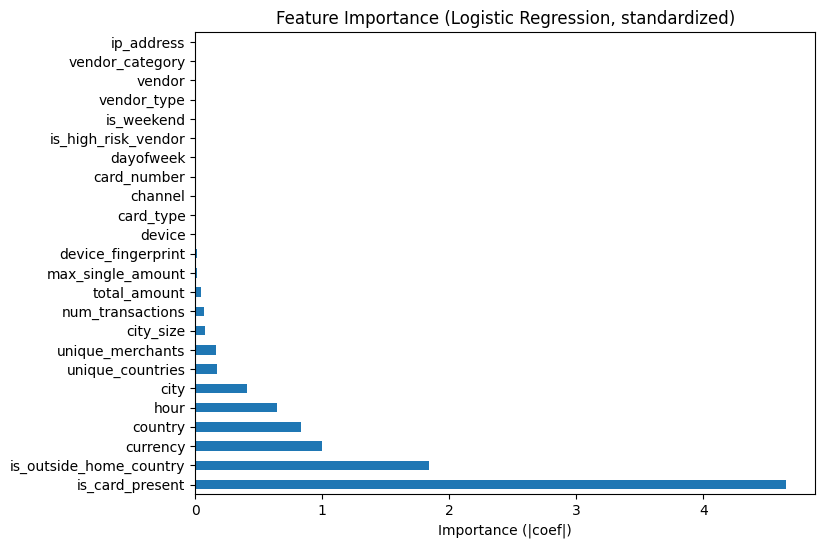

In [55]:
importance_logreg.plot(kind="barh", figsize=(8,6))
plt.title("Feature Importance (Logistic Regression, standardized)")
plt.xlabel("Importance (|coef|)")
plt.show()

In [56]:
evaluate_model("Logistic Regression", logreg_pipeline, X_train, X_test, y_train, y_test)


Метрики для Logistic Regression:
Accuracy : 0.8698303127968925
Precision: 0.6154188968067793
Recall   : 0.9284849336330551
F1-score : 0.7402108373490923
ROC AUC  : 0.9564647168460902


In [57]:
rf = RandomForestClassifier(
    n_estimators=30,
    max_depth=7,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

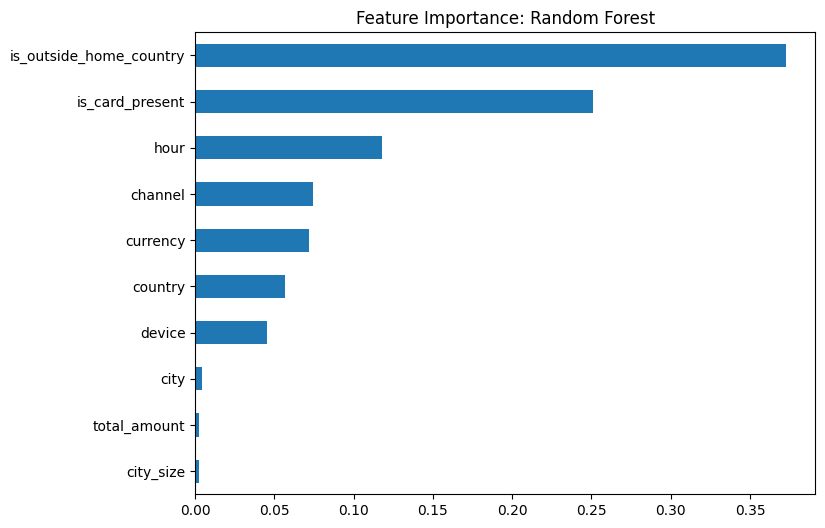

In [58]:
importance_rf = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values()
importance_rf.tail(10).plot(kind="barh", figsize=(8,6))
plt.title("Feature Importance: Random Forest")
plt.show()

In [59]:
evaluate_model("Random Forest", rf, X_train, X_test, y_train, y_test)


Метрики для Random Forest:
Accuracy : 0.9150054050298179
Precision: 0.7320585930109997
Recall   : 0.9060860897024192
F1-score : 0.8098284784902998
ROC AUC  : 0.967906382319006


In [60]:
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

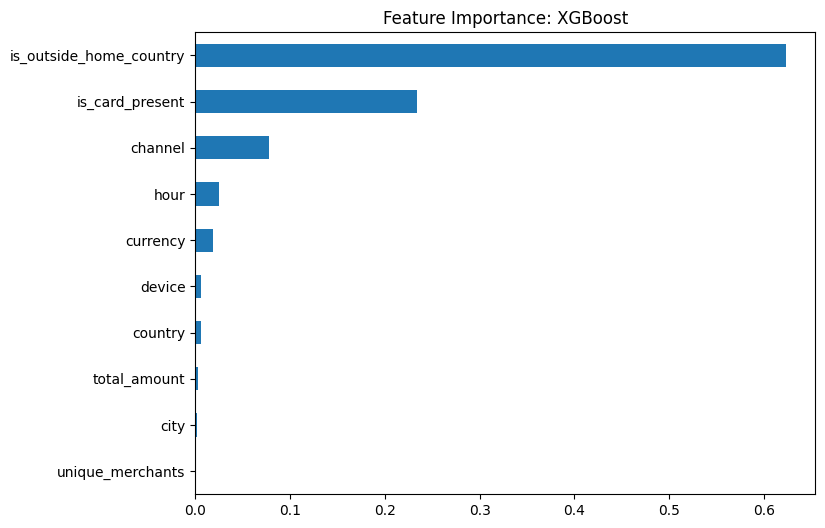

In [61]:
importance_xgb = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values()
importance_xgb.tail(10).plot(kind="barh", figsize=(8,6))
plt.title("Feature Importance: XGBoost")
plt.show()

In [62]:
evaluate_model("XGBoost", xgb, X_train, X_test, y_train, y_test)


Метрики для XGBoost:
Accuracy : 0.9235218345833718
Precision: 0.7600928283605869
Recall   : 0.9016872725326482
F1-score : 0.8248576678799896
ROC AUC  : 0.9718320287614436


In [63]:
cat = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    early_stopping_rounds=50,
    class_weights=[y_train.value_counts()[0]/len(y_train),
                   y_train.value_counts()[1]/len(y_train)],
    verbose=0,
    random_state=42,
    thread_count=-1
)

cat.fit(X_train, y_train, eval_set=(X_test, y_test))

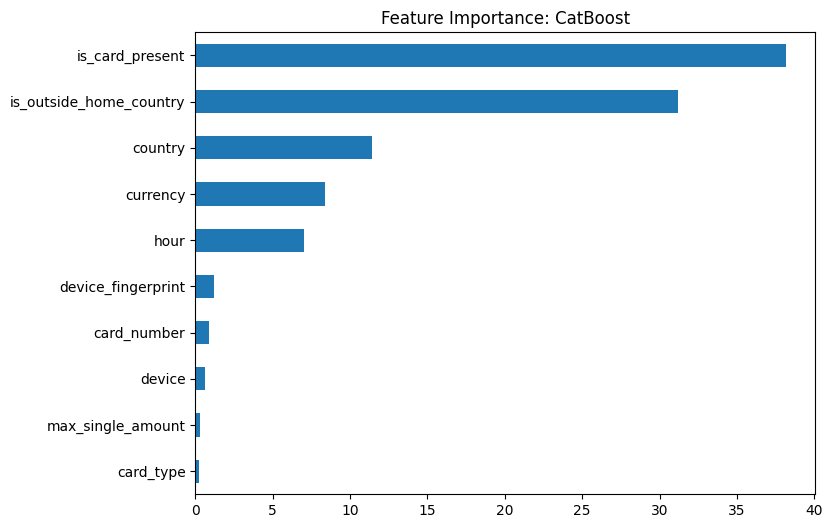

In [64]:
importance_cat = pd.Series(cat.feature_importances_, index=X_train.columns).sort_values()
importance_cat.tail(10).plot(kind="barh", figsize=(8,6))
plt.title("Feature Importance: CatBoost")
plt.show()

In [65]:
evaluate_model("CatBoost", cat, X_train, X_test, y_train, y_test)


Метрики для CatBoost:
Accuracy : 0.9212829897230941
Precision: 0.971883532378749
Recall   : 0.6239295654035538
F1-score : 0.7599722935256489
ROC AUC  : 0.9725484317666672


Accuracy мало что значит: при сильном дисбалансе классов модель может угадать почти все легитимные транзакции и получить высокий Accuracy, но пропустить фрод

Precision: среди предсказанных фродов, какая доля действительно мошенничества
Высокий Precision => меньше ложных тревог для клиентов (меньше блокировок нормальных транзакций)

Recall: среди всех мошеннических транзакций, какую долю мы нашли

Высокий Recall => мы ловим почти весь фрод, но можем ловить лишнее

В нашем случае фрод‑детекции Recall скорее более важная метрика, чем Precision:

Если мы пропустим мошенничество => убытки

Если заблокируем легитимную транзакцию по ошибке (FPR), => неприятно клиенту, но менее критично, чем потерять деньги

**CatBoost**

- Recall: 0.62 (пропускает почти 40% фрода)
- Precision: 0.97 (почти не тревожит лишних)

**XGBoost**

- Recall: 0.90 (ловит почти весь фрод)
- Precision: 0.76 (каждая четверть тревог ложная)
- F1: 0.82 (лучший баланс)

**Random Forest**

- Recall: 0.91 (даже выше XGB)
- Precision: 0.73 (ложных тревог больше, чем у XGB)
- F1: 0.81 (немного хуже XGB)

**Logistic Regression**

- Recall: 0.93
- Precision: 0.61 (много ложных тревог)

=> XGBoost для бейзлайна выглядит неплохой моделью, можно выбрать на первом этапе ее или комбинировать выходы из нескольких моделей

**=> После построения моделей и знаний о feature importance из каждой модели можем на первом этапе подозрительные транзакции отправлять на ручную проверку (или даже поставить трешхолд по вероятности флага мошенничества из модели: если очень высокая, то автоматически блокировать, иначе – проверить вручную), что в теории может сохранить компании деньги. Но, конечно, нужно посчитать импакт от этого действия и оценить целесообразность. Возможно, потраченные силы / время / деньги / ресурсы на доведение точности моделей до лучших значений сильно окупит эти затраты.**

#### Другие гипотезы

**Помимо детекции мошеннических транзакций, предоставленные данные могут помочь в решении следующих задач, которые принесут пользу бизнесу:**

- сегментация пользователей (кто-то предпочитает определенные категории, кто-то тратит больше или меньше). Это поможет персонализировать офферы для пользователей

- гео-аналитика: информация из предоставленных данных может быть полезна для гео-статистики, что может помочь для изучения новых рынков или оптимизировать затраты на маркетинг

- наличие данных об устройствах позволяет предположить, в какие из них имеет смысл вкладывать больше ресурсов в улучшение UI / ab testing и тд

- кредитный скоринг: также можем добавить признак (если имеется) о надежности клиента, а наши данные помогут добиться хорошей точности предсказаний